# Initial PCA notebook

The goal of this notebook is to look at how to plot an initial PCA of a fingerprints generated from the dataset.  
It'll look at how to get a set of fingerprints for the molecules, doing a PCA on these fingerprints, and plotting the result as a scattergraph.  It should be a useful template for doing more complex analysis in the future.

In [45]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

## 1. Load the data

In [71]:
df = pd.read_excel("mchem_data.xlsx")

# Filter the data by reaction and enzyme type
df = df[df['reaction'].isin(['Carboxylic acid reduction'])]
#df = df[df['enzyme_type'].isin(['CAR'])]
df.reset_index(inplace=True, drop=True)

df.head(n=2)

,reaction,enzyme_type,enzyme_name,short_citation,html_doi,cascade_num,substrate_1_smiles,substrate_2_smiles,product_1_smiles,temperature,...,specific_activity,conversion,conversion_time,categorical,binary,added_by,selectivity,auto_generated,paper,_id
0,Carboxylic acid reduction,CAR,NiCAR,"Ressmann et al, 2019, Adv. Synth Catal.",https://doi.org/10.1002/adsc.201900154,NaN,O=C(O)Cc1ccccc1,NaN,O=CCc1ccccc1,25,...,NaN,60.0,5.0,High,True,5ef34e052b3dd3c81352b1ee,NaN,False,5f0ded26b9d32b06f17b7c03,5f0ded26b9d32b06f17b7c05
1,Carboxylic acid reduction,CAR,NiCAR,"Ressmann et al, 2019, Adv. Synth Catal.",https://doi.org/10.1002/adsc.201900154,NaN,CCCCCCCC(=O)O,NaN,CCCCCCCC=O,25,...,NaN,10.0,5.0,Medium,True,5ef34e052b3dd3c81352b1ee,NaN,False,5f0ded26b9d32b06f17b7c03,5f0ded26b9d32b06f17b7c06


## 2. Extract lists of unique substrate or product smiles strings
(For this, we will use sets rather than lists)

In [72]:
""" 
First I want a list of all the unique product and substrate smiles.

I had to put in a filter for nan values - ie empty cells, as rdkit doesn't like these.

Loop over df and add smiles to two new sets.
(sets are like lists, but every entry must be unique)
"""

set_substrate_smiles = set()
set_product_smiles = set()
for index, row in df.iterrows():
    if str(row['substrate_1_smiles']) != 'nan':
        set_substrate_smiles.add(row['substrate_1_smiles'])
    
    if str(row['product_1_smiles']) != 'nan':
        set_product_smiles.add(row['product_1_smiles'])

print(len(set_substrate_smiles))
print(len(set_product_smiles))
#print(set_substrate_smiles)

176
173


## 3. Generate list of fingerprints which correspond to the smiles

Many different fingerprints are available.   

This is a useful resource: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiSme2EtM3tAhVsVBUIHUSCBBYQFjABegQIBBAC&url=https%3A%2F%2Fwww.rdkit.org%2FUGM%2F2012%2FLandrum_RDKit_UGM.Fingerprints.Final.pptx.pdf&usg=AOvVaw1on_e9_FUhFQ2d_SsG1Su-

Also, the rdkit page: https://rdkit.org/docs/source/rdkit.Chem.rdFingerprintGenerator.html

The default 'rdkitfingerprint' is a good one to try first, followed by morgan fingerprints.  
Also look at different fingerprint lengths (try 1024), and the morgan fingerprint radius.


In [79]:
"""
Fingerprint generators

There are lots of different types of fingerprints, and theres a couple of ways to make them through rdkit
We can get quite alot of control of how the fingerprints are made using the method below

There are more arguments you can alter from the defaults, 
see: https://rdkit.org/docs/source/rdkit.Chem.rdFingerprintGenerator.html
"""

# default rdkit fingerprints, probably try this first
rd_arguments = {'fpSize': 2048}
fp_gen_rd = rdFingerprintGenerator.GetRDKitFPGenerator(**rd_arguments)

# morgan fingerprints (also called extended connectivity fingeprints (ECFP)), also try these.
mg_arguments = {'includeChirality': True,
                'radius': 2,
                'fpSize': 2048}
fp_gen_mg = rdFingerprintGenerator.GetMorganGenerator(**mg_arguments)

# atom pair - I've not looked into these much, could be worth intestigating?
ap_arguments = {'includeChirality': True,
                'fpSize': 2048}
ap_fp_gen = rdFingerprintGenerator.GetAtomPairGenerator(**ap_arguments)

# toplogical torsion fingerprints.  I've not looked at these either yet.. also could be interesting?
tt_arguments = {'includeChirality': True,
                'fpSize': 2048}
tt_fp_gen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(**tt_arguments)


# TEST
test_smi = 'CCC(O)CCCC=O'
test_mol = Chem.MolFromSmiles(test_smi)
fp = fp_gen_rd.GetFingerprint(test_mol)
print(len(list(fp)))
#print(list(fp))

2048


In [80]:
"""
Will loop over smiles, making a corresponding list of fp's

Pick a fingerprint generator from the sell above. eg fp_gen_rd.
Use .GetFingerprint(mol) to return the fingerprint using that generator
"""

def make_list_fp(list_smi):
    list_fp = []
    for smi in list_smi:
        mol = Chem.MolFromSmiles(smi)
        fp = fp_gen_rd.GetFingerprint(mol)
        fp = list(fp)
        list_fp.append(fp)
    return list_fp

# The index of these lists should match up with the smiles lists
substrate_fps = make_list_fp(set_substrate_smiles)
product_fps = make_list_fp(set_product_smiles)

# print(product_fps[0])

## 4. Do a PCA on the fingerprints

Use sklearn to do the pca.  
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Then add the resulting 2D co-ordinates to a new dataframe, and plot using seaborn.  



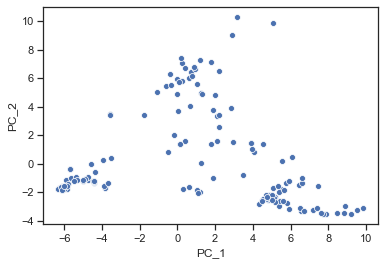

In [81]:
"""
1. Substrates
""" 

pca = PCA(n_components=2)
crds = pca.fit_transform(substrate_fps) 

pca_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])
pca_df.head()
ax = sns.scatterplot(data=pca_df,x="PC_1",y="PC_2")

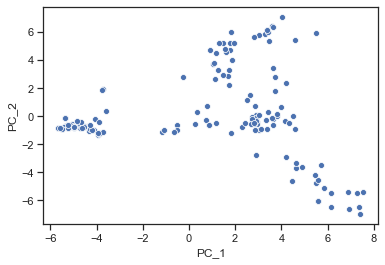

In [76]:
"""
2. Products
""" 

pca = PCA(n_components=2)
crds = pca.fit_transform(product_fps) 

pca_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])
pca_df.head()
ax = sns.scatterplot(data=pca_df,x="PC_1",y="PC_2")

# What next?

- Can we find out what the molecules are which appear to be quite different to the others? (find molecules with PC_1 > 10?  Then draw these in RDKit).  We'd need to also add the smiles lists into the PCA dataframe beforehand.  (are these maybe sugars?)

- Plot active vs non-active.  Make a plot of just specific activity / conversion, colour points like a heat map for activity.

- Colour points based on which cluster the enzyme in that row is in.  (Ie for CARs - is the data from bacterial CAR or Fungal CAR?)

- Get databases of relevent molecules, extract potential substrates (by doing a SMARTS query), include these in the PCA and overlay the activity data with the PCA data.

- Look at the same analysis as a t-sne.

- Look at different fingerprints, how much of an impact does this have?

- Create a function that can run this entire workflow.  Use this function to explore the effects of various options.

